In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm 
import pandas as pd
from scipy.integrate import odeint
import time
import statistics
import random 
import scipy.stats


### Opening predator-prey dataset

In [3]:
df = pd.read_csv('predator-prey-data.csv', index_col=False)
df.head()


,Unnamed: 0,t,x,y
0,0,0.000000,4.781635,3.035257
1,1,0.202020,6.114005,2.189746
2,2,0.404040,6.238361,1.478907
3,3,0.606061,5.520524,0.989836
4,4,0.808081,4.582546,0.957827


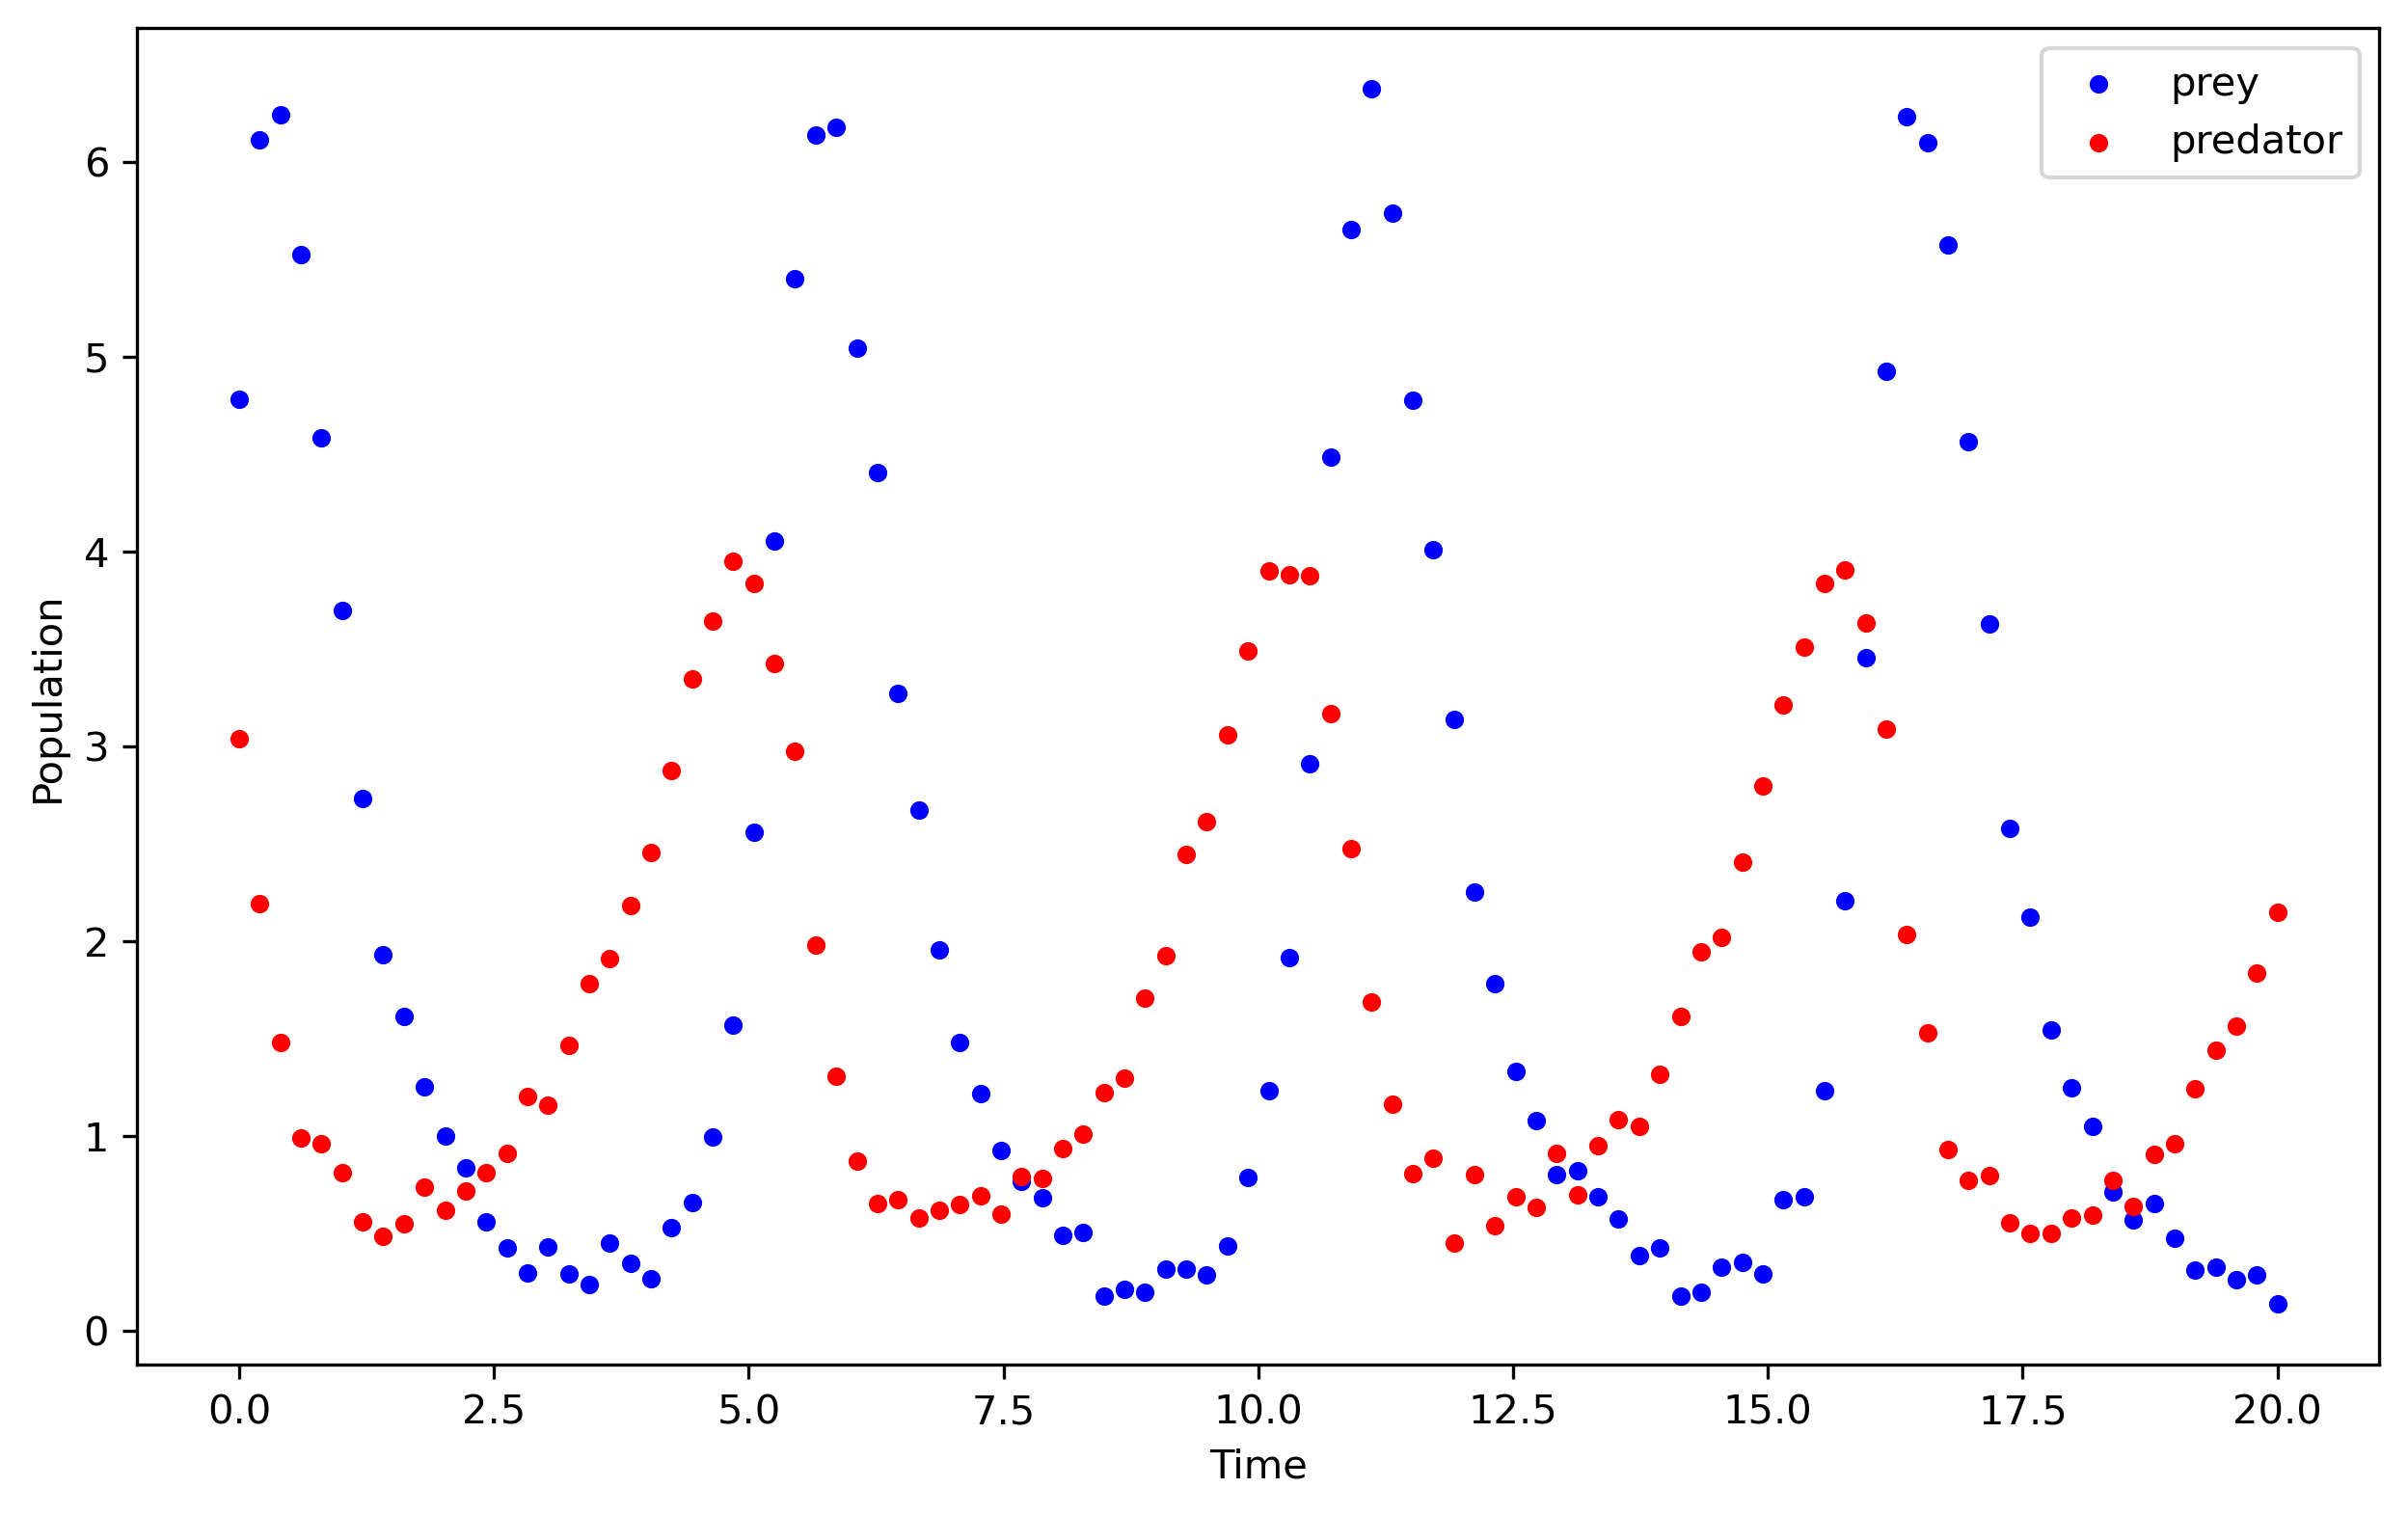

In [4]:
# Loading data into read-only numpy arrays
data = df[['t','x','y']].values
# data[1], data[2] = data[2].copy(), data[1].copy()
data.flags.writeable = False


# Plotting
plt.figure(dpi =300, figsize=(10, 6))
point_width = 13
# X should be prey
plt.scatter(data[:,0], data[:,1], label = 'prey', color = 'blue', s =point_width)
plt.scatter(data[:,0], data[:,2], label = 'predator', color = 'red', s=point_width)
plt.ylabel('Population')
plt.xlabel('Time')
plt.legend()


### Objective functions

#### Defining volterra equations function

In [5]:
def predator_prey_odes(initial_conditions,time ,alpha, beta, delta, gamma):
    x = initial_conditions[0]  # initial predator population
    y = initial_conditions[1]  # initial prey population
    dxdt = (alpha * x) - (beta * x * y)  # Predator ODE
    dydt = (delta * x * y) - (gamma * y)  # Predator ODE
    return [dxdt, dydt]

#Function that will return the data for predator and prey for a given set of parameters
def predator_prey_integration(time,initial_conditions,parameters): 
    alpha,beta,delta,gamma = parameters
    #odeint is now used as part of this function which returns the # of infected in the model
    results = odeint(predator_prey_odes,initial_conditions, time, args=(alpha,beta,delta,gamma)) 
    predator_values,prey_values = results[:,0], results[:,1]
    return np.array([predator_values,prey_values]).T


### Defining objective functions

In [6]:
# modulo linear error
def MSE(actual, predicted):
    '''Mean squared error'''
    return np.mean((actual - predicted)**2)

def MSE2(actual, predicted):
    '''Mean squared error, handles nan values'''
    x1, y1 = actual[:, 0], actual[:, 1]
    
    # Getting useful indexes
    indx_x = np.where(~np.isnan(x1))
    indx_y = np.where(~np.isnan(y1))
    x2, y2 = predicted[:, 0], predicted[:, 1]
    
    err1 = (x1[indx_x] - x2[indx_x])**2
    err2 = (y1[indx_y] - y2[indx_y])**2  
    
    # Concatenate the arrays before calculating the mean
    errors = np.concatenate([err1, err2])
    
    # Use np.nanmean to handle NaN values during the mean calculation
    return np.nanmean(errors)


def MAE(actual, predicted):
    '''Calculate Mean Absolute Error (MAE) for multidimensional data.'''
    mae = np.mean(np.abs(actual - predicted))
    return mae

def MAE2(actual, predicted):
    '''Calculate Mean Absolute Error (MAE) for multidimensional data, handles nan values.'''
    x1, y1 = actual[:, 0], actual[:, 1]

    # Getting useful indexes
    indx_x = np.where(~np.isnan(x1))
    indx_y = np.where(~np.isnan(y1))
    
    x2, y2 = predicted[:, 0], predicted[:, 1]

    err1 = np.abs(x1[indx_x] - x2[indx_x])
    err2 = np.abs(y1[indx_y] - y2[indx_y])
    
    mae = np.nanmean(np.concatenate([err1, err2]))
    
    return mae

    

### Algorithms & Optimisation

### Defining minimization algorithms

In [7]:

def random_walk(parameters, variance = 0.5):
    lst = [parameter + np.random.normal(0, 1) for parameter in parameters]
    # Ensure all elements are positive
    while any(x <= 0 for x in lst):
        for indx in range(len(lst)):
            if lst[indx] <= 0:
                while lst[indx] < 0:
                    lst[indx] = parameters[indx] + np.random.normal(0, variance)
    return lst


def hill_climbing(data, time, initial_conditions, parameters, objective, max_iterations=1000, variance = 0.5):
    '''Tries to find the best solution using random walker'''
    # Initialize starting parameter state
    scores = []
    x_n = parameters
    all_scores = []
    
    current_est = predator_prey_integration(time, initial_conditions, x_n)
    current_score = objective(data, current_est)
    scores.append(current_score)
    number_iterations= 1

    for k in range(max_iterations):
        # Generate a random walk for parameters
        x_n_1 = random_walk(x_n, variance)

        # Calculate the current and next estimations
        current_est = predator_prey_integration(time, initial_conditions, x_n)
        new_estimation = predator_prey_integration(time, initial_conditions, x_n_1)
        
        new_score = objective(data, new_estimation)

        # If the next estimation is better, update the parameters
        if new_score < current_score:
            number_iterations = k
            current_score = new_score
            x_n = x_n_1
            scores.append(current_score)

    return x_n, scores, number_iterations

In [8]:
def simulated_annealing(initial_temp,cooling_constant, data, time, initial_conditions, parameters, objective, max_iterations):

    temp = initial_temp #Scaling factor for random movement. We square root the temperature to allow for a smoother decrease in scaling as the temperature decreases
    start = parameters #Initial starting parameters
    x_n = start
    scores = [] #A score is just the value of the objective function evaluated at a certain point.

    current_est = predator_prey_integration(time, initial_conditions, x_n) #Outputs the data points of the predator prey function for the current set of parameters
    current_score = objective(data, current_est) #The current value of the objective function (which is determined by the actual data and the current estimate)
    scores.append(current_score) #Keeping track of the values of the objective function

    #cur = function(x) #The function value of the current x solution
    history = [x_n] #Stores previously searched x values

    for i in range (max_iterations):
        proposal = random_walk(x_n) #A new proposal for the parameters is generated by taking a random walk scaled by the scale
        new_est = predator_prey_integration(time, initial_conditions, proposal) #Calculate new function values based on proposal parameters
        new_score = objective(data, new_est) #Calculate new value of objective function based on new function values

        delta = new_score - current_score #Difference in objective function values

        #if proposal < 0 or proposal > 1:
           #proposal = x_n # Reject proposal by setting it equal to previous x_n if it is not in the correct range
    
        acceptance_probability = min(np.exp(-(delta/temp)),1)#Calculate acceptance probability

        #if delta < 0:
           #x_n = proposal ##Accept proposal
            #current_score = new_score

        if np.random.rand() < acceptance_probability: #else if it is not negative (meaning it is a bad proposal), we may still accept it with the probability in the brackets, which depends on how high temp is
            x_n = proposal #Accept proposal
            current_score = new_score

        scores.append(current_score)
        temp = cooling_constant**i * initial_temp #Cool temperature
        #print(temp)
        history.append(x_n) #Add to history
    
    return x_n, scores

        
        

### Multiple run algorithms

In [9]:
def uniform_draw_g(lower_bound, upper_bound):
    while True:
        yield np.random.uniform(lower_bound, upper_bound)

def multiple_runs_annealing(initial_temp,cooling_constant,input_data,t,parameters,objective_function,n_runs,iterations=1000): #Runs the annlealing algorithm miltiple times and returns the a list of MSE for each simulation

    mse_total_list = []
    all_all_best = []
    
    for i in range(n_runs):
        
        x_best, scores = simulated_annealing(initial_temp,cooling_constant, input_data, t, input_data[0], parameters, objective_function, max_iterations=iterations)
        all_all_best.append(x_best)
        
        x = predator_prey_integration(t,initial_conditions,x_best) 
        mse_prey = MSE(data[:,1],x[:,0]) 
        mse_predator = MSE(data[:,2],x[:,1])
        mse_total = mse_prey + mse_predator
    
        mse_total_list.append(mse_total) #Add total MSE for this simulation to the MSE list
    
    return np.array(all_all_best) , mse_total_list



def multi_run_hill_climbing(data, objective, nruns = 50, nsamples=100, variance=0.5):
    initial_conditions = data[0][1:3]
    time = data[:,0]

    # Defining generators for variables
    alpha = uniform_draw_g(0,1)
    beta = uniform_draw_g(0,1)
    delta = uniform_draw_g(0,1)
    gamma = uniform_draw_g(0,1)

    # Lists for storing values
    parameter_list = []
    best = []
    best_score = float('inf')
    best_param = None
    num_iterations = []
    
    # Running simulation for 
    for __ in range(nruns): 
        
        parameters = [next(alpha), next(beta), next(delta), next(gamma)]
        params, score, iterations = hill_climbing(data[:,1:3], time, initial_conditions, parameters, objective, max_iterations=nsamples,variance=variance)
        parameter_list.append(params)
        num_iterations.append(iterations)
        scores.append(score)

        #Saving best parameter combination
        if score[-1] < best_score:
            best_score = score[-1]
            best_param = params

    parameter_list = np.array(parameter_list)
    
    return parameter_list, best_param, scores, best_score, num_iterations


### Plotting hill climbing

In [10]:
input_data = data[:,1:3]
# t = 
initial_conditions = [input_data[0][0], input_data[0][1]]

alpha = np.random.uniform(0.5, 2)
beta = np.random.uniform(0.5, 2)
delta = np.random.uniform(0.5, 2)
gamma = np.random.uniform(0.5, 2)
parameters = [alpha, beta, delta, gamma]

# Using MSEx
x_best, scores, num_iterations = hill_climbing(input_data, data[:,0], input_data[0], parameters, MAE, max_iterations=100, variance=0.5 )
print(x_best,scores,num_iterations)

[2.058470826384955, 3.3348226913782497, 0.33391386324627437, 0.07775331273010042] [1.7841476511911036, 1.7630633552849264, 1.7463166480090968, 1.7416628363579707, 1.7024628624472102, 1.6549539797197672, 1.541264871748595] 16


### Plotting hill climbing results

<Figure size 1000x800 with 0 Axes>

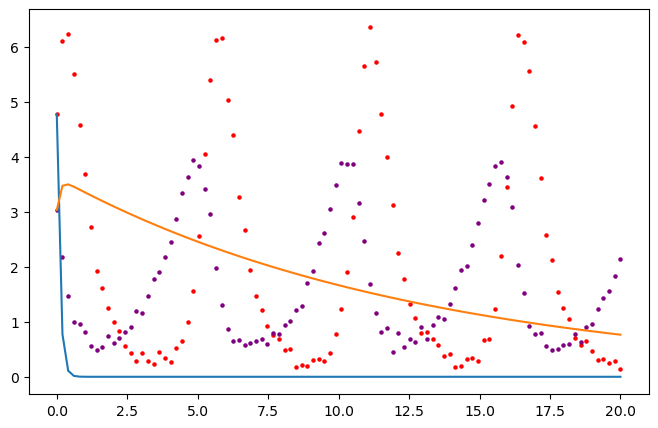

<Figure size 1000x800 with 0 Axes>

In [11]:
# t, x ,y = data
initial_conditions = [input_data[0][0], input_data[0][1]]
t = data[:,0]

parameters = x_best
# Using MSE
x = predator_prey_integration(t,initial_conditions,parameters)

# Increase the figure size
plt.figure(figsize=(8, 5))  

plt.plot(t, x[:,0])
plt.plot(t, x[:,1])

plt.scatter(t, data[:,1], color= 'red', s =5)
plt.scatter(t, data[:,2], color= 'purple', s=5)

plt.figure(figsize=(10, 8))  

## Running simulation for different random walker variance

In [ ]:
# parameter_list = np.array(parameter_list)
# # Create a figure with 3x3 subplotshttp://localhost:8888/notebooks/Desktop/Computational%20Science/Stochastic%20simulation/Stochastic-modelling/stochastic_assignment_3/assignment3.ipynb#Running-simulation-for-different-random-walker-variance
# fig, axes = plt.subplots(3, 3, figsize=(12, 12), sharex=True)

# # Plot histograms on each subplot using for loops with the same color
# color = 'blue'
# titles = ['variance = 0.1', 'variance=0.25', 'variance=0.5']
# x_titles = ['alpha', 'beta', 'delta', 'omega']

# for i in range(3):
#     for j in range(3):
#         ax = axes[i, j]
#         ax.hist(parameter_list[j][:,i])
#         ax.set_xlabel(x_titles[i])
#         ax.set_ylabel('Frequency')
#         ax.set_title(titles[j])

# # Adjust layout to prevent overlapping
# plt.tight_layout()

# # Show the plot
# plt.show()


### Running multi run for hill climbing

In [12]:

# We save the parameter estimation we will use as ground truth for testing
parameter_list, reference_param, scores, reference_score, num_iterations = multi_run_hill_climbing(data, MSE,nruns = 200)

# Integrating with best guess
results = predator_prey_integration(t,initial_conditions,reference_param)

# Increase the figure size
plt.figure(figsize=(8, 5))  

plt.plot(data[:,0], results[:,0])
plt.plot(data[:,0], results[:,1])

plt.scatter(t, data[:,1], color= 'red', s =5)
plt.scatter(t, data[:,2], color= 'purple', s=5)

plt.show()


C:\Users\Aleks\AppData\Local\anaconda3\Lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


KeyboardInterrupt: 

# Kaya's code section: Points removal

In [13]:
def point_removal(time, input_data, points_removed, Focus = 'both'):
    '''removes points randomly'''
    
    #We set the seed for removing points
    random.seed(123)
    
    prey = input_data.T[0].copy()
    predator = input_data.T[1].copy()
    
    # initialize set up for removing points randomly given the bounds 
    removal_options = np.arange(0,len(time))
    
    # choose points to be removed randomly
    if points_removed > len(removal_options):
        points_removed = len(removal_options)
        print('WARNING: Maximum number of points that can be removed has been exceeded. All points possible within the given bound have now been removed.')
    removed_points_indices = random.choices(removal_options, k = points_removed)
    
    # remove points based on choices for points to be removed
    if Focus == 'both':
        for i in removed_points_indices:
            prey[i] = None
            predator[i] = None
        
    elif Focus == 'prey':  
        for i in removed_points_indices:
            prey[i] = None
        
    elif Focus == 'predator':
        for i in removed_points_indices:
            predator[i] = None
    
    return np.array([time, prey, predator]).T



In [14]:
def extrema_removal(time, input_data, points_removed, Focus = 'both'):
    '''Removes points in extrema'''
    prey = input_data.T[0].copy()
    predator = input_data.T[1].copy()
    
    # Calculate mean and variance to set regions for data
    mean_prey_population, mean_predator_population = np.mean(prey), np.mean(predator)
    variance_prey, variance_predator = statistics.variance(prey), statistics.variance(predator)
    
    # set upper bound and lower bound for point removals
    ub_prey, lb_prey = mean_prey_population + 1.645*variance_prey/len(time), mean_prey_population - 1.645*variance_prey/len(time)
    ub_predator, lb_predator = mean_predator_population + 1.645*variance_predator/len(time), mean_predator_population - 1.645*variance_predator/len(time)
    
    # initialize set up for removing points randomly given the bounds 
    prey_options = []
    predator_options = []
    # enumerate through list of stored points
    for index, prey_count in enumerate(prey):
        # check if they are in specified region
        if prey_count > ub_prey or prey_count < lb_prey:
            prey_options.append([index, prey_count, predator[index]])
    for index, predator_count in enumerate(predator):
        if predator_count > ub_predator or predator_count < lb_predator:
            predator_options.append([index, prey[index], predator_count])
    
    # remove points from list depending on which focus is set
    removal_options = []
    if Focus == 'both': 
        removal_options = removal_options + prey_options + predator_options
    elif Focus == 'prey':
        removal_options = removal_options + prey_options
    elif Focus == 'predator':
        removal_options = removal_options + predator_options
    else:
        print('Error: Removal option not known. Try either both, prey, or predator as an alternative.')
    
    # choose points to be removed randomly
    if points_removed > len(removal_options):
        points_removed = len(removal_options)
        print('WARNING: Maximum number of points that can be removed has been exceeded. All points possible within the given bound have now been removed.')
    removed_points_indices = random.choices(np.array(removal_options).T[0], k = points_removed)
    
    # turn the list into integers so we can remove them based on the indices
    integer_array = []
    for counter in range(len(removed_points_indices)):
        integer_array.append(int(removed_points_indices[counter]))
    
    # update the lists based on points we wanted to remove 
    if Focus == 'both':
        for i in integer_array:
            prey[i] = None
            predator[i] = None
        
    elif Focus == 'prey':  
        for i in integer_array:
            prey[i] = None
        
    elif Focus == 'predator':
        for i in integer_array:
            predator[i] = None
    
    return np.array(time), np.array(prey), np.array(predator)

# extrema_removal(t, input_data, 5, Focus = 'both')

In [15]:
def midpoint_removal(time, input_data, points_removed, Focus = 'both'):
    '''Removes points close to the mean'''
    prey = input_data.T[0].copy()
    predator = input_data.T[1].copy()
    
    # Calculate mean and variance to set regions for data
    mean_prey_population, mean_predator_population = np.mean(prey), np.mean(predator)
    variance_prey, variance_predator = statistics.variance(prey), statistics.variance(predator)
    
    # set upper bound and lower bound for point removals
    ub_prey, lb_prey = mean_prey_population + 1.645*variance_prey/len(time), mean_prey_population - 1.645*variance_prey/len(time)
    ub_predator, lb_predator = mean_predator_population + 1.645*variance_predator/len(time), mean_predator_population - 1.645*variance_predator/len(time)
    
    # initialize set up for removing points randomly given the bounds 
    prey_options = []
    predator_options = []
    # enumerate through list of stored points
    for index, prey_count in enumerate(prey):
        # check if they are in specified region
        if prey_count <= ub_prey or prey_count >= lb_prey:
            prey_options.append([index, prey_count, predator[index]])
    for index, predator_count in enumerate(predator):
        if predator_count <= ub_predator or predator_count >= lb_predator:
            predator_options.append([index, prey[index], predator_count])
    
    # remove points from list depending on which focus is set
    removal_options = []
    if Focus == 'both': 
        removal_options = removal_options + prey_options + predator_options
    elif Focus == 'prey':
        removal_options = removal_options + prey_options
    elif Focus == 'predator':
        removal_options = removal_options + predator_options
    else:
        print('Error: Removal option not known. Try either both, prey, or predator as an alternative.')
    
    # choose points to be removed randomly
    if points_removed > len(removal_options):
        points_removed = len(removal_options)
        print('WARNING: Maximum number of points that can be removed has been exceeded. All points possible within the given bound have now been removed.')
    removed_points_indices = random.choices(np.array(removal_options).T[0], k = points_removed)
    
    # turn the list into integers so we can remove them based on the indices
    integer_array = []
    for counter in range(len(removed_points_indices)):
        integer_array.append(int(removed_points_indices[counter]))
    
    # update the lists based on points we wanted to remove 
    if Focus == 'both':
        for i in integer_array:
            prey[i] = None
            predator[i] = None
        
    elif Focus == 'prey':  
        for i in integer_array:
            prey[i] = None
        
    elif Focus == 'predator':
        for i in integer_array:
            predator[i] = None
    
    return np.array([time, prey, predator]).T


In [ ]:
# 1. Run multi run for different size datasets save best parameters
# 2.Calculate MSE for each run for best parameters
# 2. Do this for 2x, one only for predator, other for prey
# 4. Plot error relative to best solution of y axis
# 5. On x axis should be relative number points


# Hypothesis testing random removal points (Aleks section)

### Duplicating code for the functions I use in case they are different 

In [ ]:
def random_walk(parameters, variance = 0.5):
    lst = [parameter + np.random.normal(0, 1) for parameter in parameters]
    # Ensure all elements are positive
    while any(x <= 0 for x in lst):
        for indx in range(len(lst)):
            if lst[indx] <= 0:
                while lst[indx] < 0:
                    lst[indx] = parameters[indx] + np.random.normal(0, variance)
    return lst


def hill_climbing(data, time, initial_conditions, parameters, objective, max_iterations=1000, variance = 0.5):
    '''Tries to find the best solution using random walker'''
    # Initialize starting parameter state
    scores = []
    x_n = parameters
    all_scores = []
    
    current_est = predator_prey_integration(time, initial_conditions, x_n)
    current_score = objective(data, current_est)
    scores.append(current_score)
    number_iterations= 1

    for k in range(max_iterations):
        # Generate a random walk for parameters
        x_n_1 = random_walk(x_n, variance)

        # Calculate the current and next estimations
        current_est = predator_prey_integration(time, initial_conditions, x_n)
        new_estimation = predator_prey_integration(time, initial_conditions, x_n_1)
        
        new_score = objective(data, new_estimation)

        # If the next estimation is better, update the parameters
        if new_score < current_score:
            number_iterations = k
            current_score = new_score
            x_n = x_n_1
            scores.append(current_score)

    return x_n, scores, number_iterations

def simulated_annealing(initial_temp,cooling_constant, data, time, initial_conditions, parameters, objective, max_iterations):

    temp = initial_temp #Scaling factor for random movement. We square root the temperature to allow for a smoother decrease in scaling as the temperature decreases
    start = parameters #Initial starting parameters
    x_n = start
    scores = [] #A score is just the value of the objective function evaluated at a certain point.

    current_est = predator_prey_integration(time, initial_conditions, x_n) #Outputs the data points of the predator prey function for the current set of parameters
    current_score = objective(data, current_est) #The current value of the objective function (which is determined by the actual data and the current estimate)
    scores.append(current_score) #Keeping track of the values of the objective function

    #cur = function(x) #The function value of the current x solution
    history = [x_n] #Stores previously searched x values

    for i in range (max_iterations):
        proposal = random_walk(x_n) #A new proposal for the parameters is generated by taking a random walk scaled by the scale
        new_est = predator_prey_integration(time, initial_conditions, proposal) #Calculate new function values based on proposal parameters
        new_score = objective(data, new_est) #Calculate new value of objective function based on new function values

        delta = new_score - current_score #Difference in objective function values

        #if proposal < 0 or proposal > 1:
           #proposal = x_n # Reject proposal by setting it equal to previous x_n if it is not in the correct range
    
        acceptance_probability = min(np.exp(-(delta/temp)),1)#Calculate acceptance probability

        #if delta < 0:
           #x_n = proposal ##Accept proposal
            #current_score = new_score

        if np.random.rand() < acceptance_probability: #else if it is not negative (meaning it is a bad proposal), we may still accept it with the probability in the brackets, which depends on how high temp is
            x_n = proposal #Accept proposal
            current_score = new_score

        scores.append(current_score)
        temp = cooling_constant**i * initial_temp #Cool temperature
        #print(temp)
        history.append(x_n) #Add to history
    
    return x_n, scores


def uniform_draw_g(lower_bound, upper_bound):
    while True:
        yield np.random.uniform(lower_bound, upper_bound)

def multiple_runs_annealing(initial_temp,cooling_constant,input_data,t,parameters,objective_function,n_runs,iterations=1000): #Runs the annlealing algorithm miltiple times and returns the a list of MSE for each simulation

    mse_total_list = []
    all_all_best = []
    
    for i in range(n_runs):
        
        x_best, scores = simulated_annealing(initial_temp,cooling_constant, input_data, t, input_data[0], parameters, objective_function, max_iterations=iterations)
        all_all_best.append(x_best)
        
        x = predator_prey_integration(t,initial_conditions,x_best) 
        mse_prey = MSE(data[:,1],x[:,0]) 
        mse_predator = MSE(data[:,2],x[:,1])
        mse_total = mse_prey + mse_predator
    
        mse_total_list.append(mse_total) #Add total MSE for this simulation to the MSE list
    
    return np.array(all_all_best) , mse_total_list



def multi_run_hill_climbing(data, objective, nruns = 50, nsamples=100, variance=0.5):
    initial_conditions = data[0][1:3]
    time = data[:,0]

    # Defining generators for variables
    alpha = uniform_draw_g(0,1)
    beta = uniform_draw_g(0,1)
    delta = uniform_draw_g(0,1)
    gamma = uniform_draw_g(0,1)

    # Lists for storing values
    parameter_list = []
    best = []
    best_score = float('inf')
    best_param = None
    num_iterations = []
    
    # Running simulation for 
    for __ in range(nruns): 
        
        parameters = [next(alpha), next(beta), next(delta), next(gamma)]
        params, score, iterations = hill_climbing(data[:,1:3], time, initial_conditions, parameters, objective, max_iterations=nsamples,variance=variance)
        parameter_list.append(params)
        num_iterations.append(iterations)
        scores.append(score)

        #Saving best parameter combination
        if score[-1] < best_score:
            best_score = score[-1]
            best_param = params

    parameter_list = np.array(parameter_list)
    
    return parameter_list, best_param, scores, best_score, num_iterations


def point_removal(time, input_data, points_removed, Focus = 'both'):
    '''removes points randomly'''
    
    #We set the seed for removing points
    random.seed(123)
    
    prey = input_data.T[0].copy()
    predator = input_data.T[1].copy()
    
    # initialize set up for removing points randomly given the bounds 
    removal_options = np.arange(0,len(time))
    
    # choose points to be removed randomly
    if points_removed > len(removal_options):
        points_removed = len(removal_options)
        print('WARNING: Maximum number of points that can be removed has been exceeded. All points possible within the given bound have now been removed.')
    removed_points_indices = random.choices(removal_options, k = points_removed)
    
    # remove points based on choices for points to be removed
    if Focus == 'both':
        for i in removed_points_indices:
            prey[i] = None
            predator[i] = None
        
    elif Focus == 'prey':  
        for i in removed_points_indices:
            prey[i] = None
        
    elif Focus == 'predator':
        for i in removed_points_indices:
            predator[i] = None
    
    return np.array([time, prey, predator]).T

### Getting distribution of averages of best guesses for hill climbing (reference dataset)

In [22]:
# We get the reference distribution for testing 

# Timing your code
start_time = time.time()

# Reference distribution of averages
ref_average1 = []
for k in range(50):
    parameter_list, best_param, scores, best_score, num_iterations = multi_run_hill_climbing(data, MSE2, nruns=20, nsamples=150)
    # Appending average
    ref_average1.append(np.mean(parameter_list, axis=0))

ref_average1 = np.array(ref_average1)

end_time = time.time()

# Calculating and printing the total time
total_time = end_time - start_time
print(f"Total time taken: {total_time} seconds")

# param_distribution, reference_param, scores, reference_score, num_iterations = multi_run_hill_climbing(data, MSE,nruns = 50, nsamples = 200)

Total time taken: 439.93707609176636 seconds


### These histograms plots are optional (I dont think im adding them to the report)

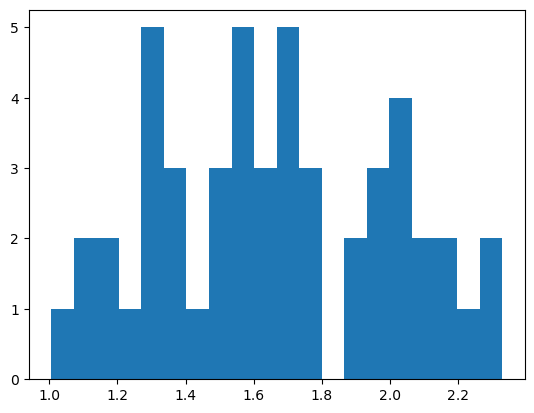

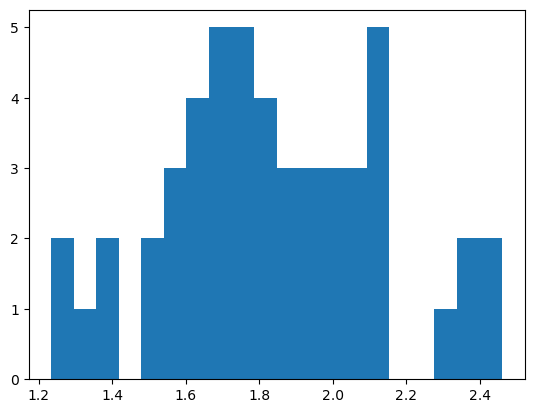

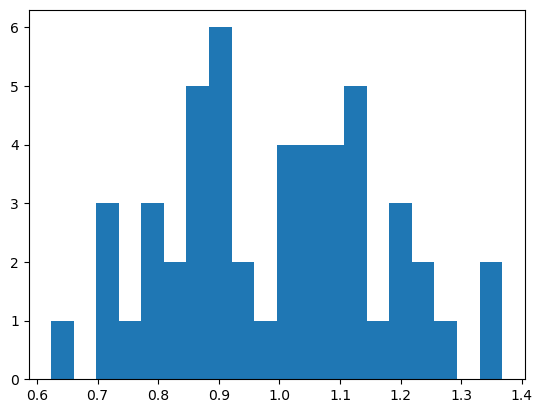

[0.1170307  0.08449044 0.02953349 0.11417836]


In [24]:
# num_iterations
# print(ref_average)
# for k in range(3):
#         plt.hist(ref_average1[:,k], bins = 20)
#         plt.show()

# print(np.var(ref_average1,axis=0))

In [25]:
# # print(param_distribution)
# plt.axvline(x=reference_param[0], color='r', linestyle='--', label='Vertical Line at x=2.5')
# plt.hist(param_distribution[:,0], bins =30)

NameError: name 'reference_param' is not defined

## Running welch test between reference distribution of averages and incomplete time series (hill climbing)

In [27]:
def random_point_ttests(data,ref_distribution, points_removed, focus_choices = ['prey', 'predator', 'both']):
    '''runs welch test for multi run of hill climbing for every parameter'''
    param_distribution = ref_distribution
#     focus_choices = ['prey', 'predator', 'both']
#     focus_choices = ['prey', 'predator', 'both']
    scores = [[],[]]
    p_values = {'prey': [], 'predator': [], 'both': []}

    for indx, choice in enumerate(focus_choices):
        print(choice)
        for npoints in points_removed:
            print(npoints)
    #         print(f"Points removed: {npoints}")
            limited_data = point_removal(data[:,0], data[:,1:3], npoints, Focus = choice)
            #Getting distribution of averages
            average_distribution = []
            for k in range(30):
                parameter_list, best_param, scores, best_score, num_iterations = multi_run_hill_climbing(limited_data, MSE2,nruns = 10, nsamples = 100)
                #Appending average
                average_distribution.append(np.mean(parameter_list, axis=0))
         
            average_distribution = np.array(average_distribution)
            t_stat1, p_value1 = scipy.stats.ttest_ind(ref_distribution[:,0], average_distribution[:,0], equal_var=False)
            t_stat2, p_value2 = scipy.stats.ttest_ind(ref_distribution[:,1], average_distribution[:,1], equal_var=False)
            t_stat3, p_value3 = scipy.stats.ttest_ind(ref_distribution[:,2], average_distribution[:,2], equal_var=False)
            t_stat3, p_value4 = scipy.stats.ttest_ind(ref_distribution[:,3], average_distribution[:,3], equal_var=False)
            p_values[choice].append([p_value1, p_value2, p_value3, p_value4])
            
    return p_values
  
        

In [28]:
start_time = time.time()
p_values_hill_climbing =random_point_ttests(data,ref_average1, np.arange(3,16,3), ['prey', 'predator', 'both'])

end_time = time.time()

# Calculating and printing the total time
total_time = end_time - start_time
print(f"Total time taken: {total_time} seconds")

prey
3
6
9
12
15


C:\Users\Aleks\AppData\Local\anaconda3\Lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


predator
3
6
9
12
15


C:\Users\Aleks\AppData\Local\anaconda3\Lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Aleks\AppData\Local\anaconda3\Lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Run terminated (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


both
3
6
9
12
15
Total time taken: 1060.7844800949097 seconds


### Visualizing p-values from welch test for hill climbing

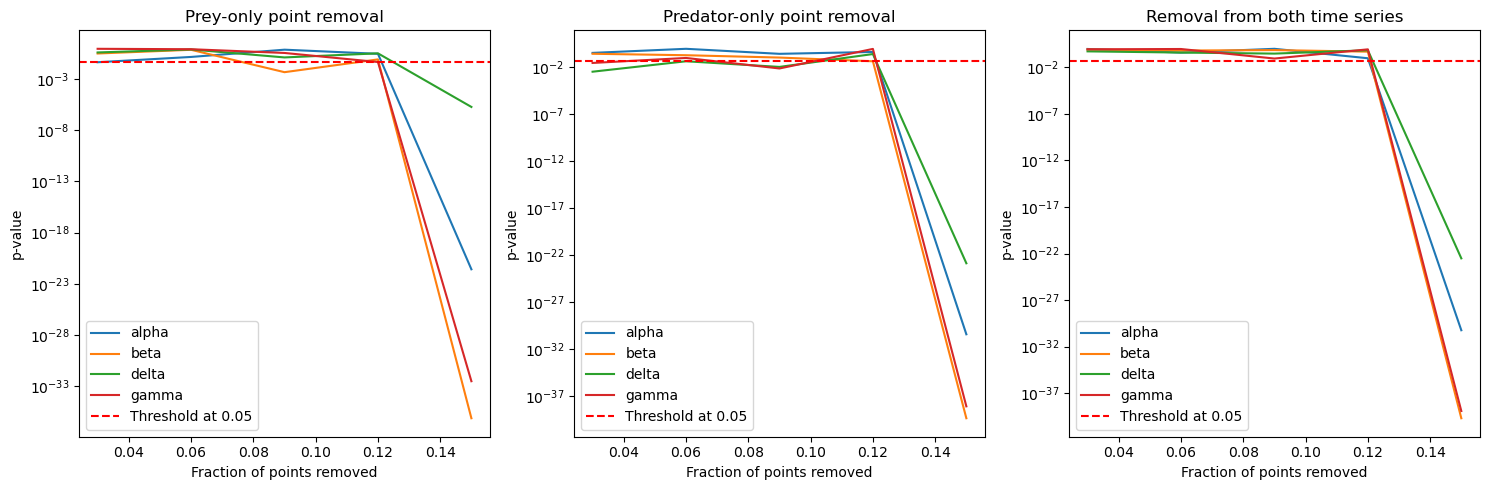

In [43]:

# Fraction points removed
fraction_points = np.arange(3,16,3) / 100
p_values_prey = np.array(p_values_hill_climbing['prey'])
p_values_predator = np.array(p_values_hill_climbing['predator'])
p_values_both = np.array(p_values_hill_climbing['both'])

# Creating subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plotting p-values when only prey points are removed
axes[0].plot(fraction_points, p_values_prey[:, 0], label='alpha')
axes[0].plot(fraction_points, p_values_prey[:, 1], label='beta')
axes[0].plot(fraction_points, p_values_prey[:, 2], label='delta')
axes[0].plot(fraction_points, p_values_prey[:, 3], label='gamma')
axes[0].axhline(y=0.05, color='r', linestyle='--', label='Threshold at 0.05')
axes[0].set_ylabel('p-value')
axes[0].set_xlabel('Fraction of points removed')
axes[0].set_yscale('log')
axes[0].set_title('Prey-only point removal')  # Add title to the first subplot
axes[0].legend()

# Plotting p-values when only predator points are removed
axes[1].plot(fraction_points, p_values_predator[:, 0], label='alpha')
axes[1].plot(fraction_points, p_values_predator[:, 1], label='beta')
axes[1].plot(fraction_points, p_values_predator[:, 2], label='delta')
axes[1].plot(fraction_points, p_values_predator[:, 3], label='gamma')
axes[1].axhline(y=0.05, color='r', linestyle='--', label='Threshold at 0.05')
axes[1].set_ylabel('p-value')
axes[1].set_xlabel('Fraction of points removed')
axes[1].set_yscale('log')
axes[1].set_title('Predator-only point removal')
axes[1].legend()

# Plotting p-values when both prey and predator points are removed
axes[2].plot(fraction_points, p_values_both[:, 0], label='alpha')
axes[2].plot(fraction_points, p_values_both[:, 1], label='beta')
axes[2].plot(fraction_points, p_values_both[:, 2], label='delta')
axes[2].plot(fraction_points, p_values_both[:, 3], label='gamma')
axes[2].axhline(y=0.05, color='r', linestyle='--', label='Threshold at 0.05')
axes[2].set_ylabel('p-value')
axes[2].set_xlabel('Fraction of points removed')
axes[2].set_yscale('log')
axes[2].set_title('Removal from both time series')
axes[2].legend()

# Adjusting layout
plt.tight_layout()
plt.savefig('welch_tests_hill_climbing', dpi = 300)
plt.show()


### Getting distribution of averages of best guesses for simulated annealing (reference dataset)

In [40]:
# We get the reference distribution for testing 

# Timing your code
start_time = time.time()

initial_temp = 20
cooling_constant = 0.10

#Taking random draw for initial parameters (initial guess)
alpha = np.random.uniform(0,1)
beta = np.random.uniform(0,1)
delta = np.random.uniform(0,1)
gamma = np.random.uniform(0,1)
parameters = [alpha, beta, delta, gamma]
parameters = [alpha, beta, delta, gamma]

# Reference distribution of averages
ref_average2 = []
for k in range(50):
#     parameter_list, best_param, scores, best_score, num_iterations = multi_run_hill_climbing(data, MSE2, nruns=20, nsamples=150)
    parameter_list, scores= multiple_runs_annealing(initial_temp,cooling_constant,data[:,1:3],data[:,0],parameters,MSE,n_runs=10,iterations=1000)
    # Appending average
    ref_average2.append(np.mean(parameter_list, axis=0))

ref_average2 = np.array(ref_average2)
end_time = time.time()

# Calculating and printing the total time
total_time = end_time - start_time
print(f"Total time taken: {total_time} seconds")

C:\Users\Aleks\AppData\Local\Temp\ipykernel_764\951072704.py:25: RuntimeWarning: overflow encountered in exp
  acceptance_probability = min(np.exp(-(delta/temp)),1)#Calculate acceptance probability
C:\Users\Aleks\AppData\Local\Temp\ipykernel_764\951072704.py:25: RuntimeWarning: overflow encountered in scalar divide
  acceptance_probability = min(np.exp(-(delta/temp)),1)#Calculate acceptance probability
C:\Users\Aleks\AppData\Local\Temp\ipykernel_764\951072704.py:25: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_probability = min(np.exp(-(delta/temp)),1)#Calculate acceptance probability


Total time taken: 1028.2772996425629 seconds


[0.35481283 0.29947082 0.18320262 0.4135741 ]


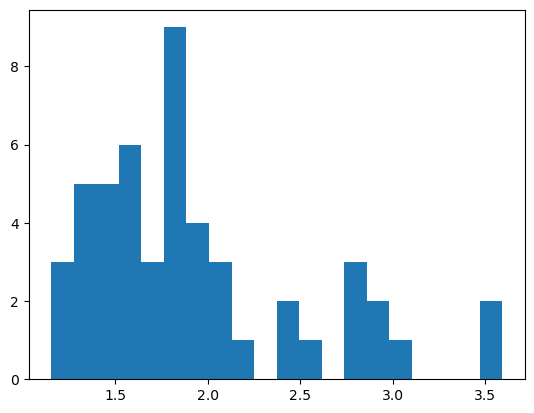

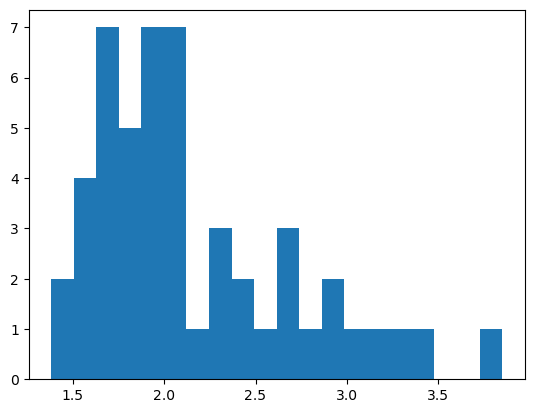

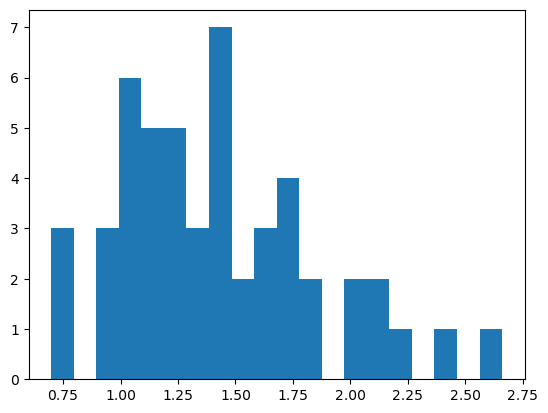

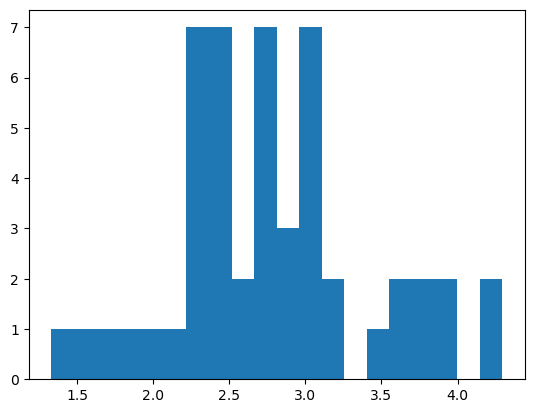

In [41]:
# print(np.var(ref_average1,axis=0))
print(np.var(ref_average2,axis=0))

for k in range(4):
        plt.hist(ref_average2[:,k], bins = 20)
        plt.show()


In [20]:
def random_point_ttests2(data,ref_distribution, points_removed, focus_choices = ['prey', 'predator', 'both']):
    '''runs welch test for multi run of simulated annealing for every parameter'''
    param_distribution = ref_distribution
#     focus_choices = ['prey', 'predator', 'both']
#     focus_choices = ['prey', 'predator', 'both']
    scores = [[],[]]
    p_values = {'prey': [], 'predator': [], 'both': []}
    initial_temp = 20
    cooling_constant = 0.10
    
    for indx, choice in enumerate(focus_choices):
        print(choice)
        #We Iteratively increase the amount of points we remove
        for npoints in points_removed:
            print(f"points: {npoints}")
    #         print(f"Points removed: {npoints}")
            limited_data = point_removal(data[:,0], data[:,1:3], npoints, Focus = choice)
            #Getting distribution of averages
            average_distribution = []
            for k in range(30):
                parameter_list, best_score = multiple_runs_annealing(initial_temp,cooling_constant,limited_data[:,1:3], t ,parameters,MSE2,n_runs= 5, iterations = 1000)
                #Appending average
                average_distribution.append(np.mean(parameter_list, axis=0))
         
            average_distribution = np.array(average_distribution)
            t_stat1, p_value1 = scipy.stats.ttest_ind(ref_distribution[:,0], average_distribution[:,0], equal_var=False)
            t_stat2, p_value2 = scipy.stats.ttest_ind(ref_distribution[:,1], average_distribution[:,1], equal_var=False)
            t_stat3, p_value3 = scipy.stats.ttest_ind(ref_distribution[:,2], average_distribution[:,2], equal_var=False)
            t_stat3, p_value4 = scipy.stats.ttest_ind(ref_distribution[:,3], average_distribution[:,3], equal_var=False)
            p_values[choice].append([p_value1, p_value2, p_value3, p_value4])
            
    return p_values

In [44]:
start_time = time.time()

# Calculating p-values for t-test
points_removed_annealing = np.arange(3,16,3)
p_values_annealing = random_point_ttests2(data,ref_average2,points_removed_annealing)

end_time = time.time()
# Calculating and printing the total time
total_time = end_time - start_time
print(f"Total time taken: {total_time/60} min")

prey
points: 3


C:\Users\Aleks\AppData\Local\Temp\ipykernel_764\951072704.py:25: RuntimeWarning: overflow encountered in exp
  acceptance_probability = min(np.exp(-(delta/temp)),1)#Calculate acceptance probability
C:\Users\Aleks\AppData\Local\Temp\ipykernel_764\951072704.py:25: RuntimeWarning: overflow encountered in scalar divide
  acceptance_probability = min(np.exp(-(delta/temp)),1)#Calculate acceptance probability
C:\Users\Aleks\AppData\Local\Temp\ipykernel_764\951072704.py:25: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_probability = min(np.exp(-(delta/temp)),1)#Calculate acceptance probability


points: 6
points: 9
points: 12
points: 15


C:\Users\Aleks\AppData\Local\Temp\ipykernel_764\951072704.py:25: RuntimeWarning: invalid value encountered in scalar divide
  acceptance_probability = min(np.exp(-(delta/temp)),1)#Calculate acceptance probability
C:\Users\Aleks\AppData\Local\Temp\ipykernel_764\264107711.py:4: RuntimeWarning: overflow encountered in scalar multiply
  dxdt = (alpha * x) - (beta * x * y)  # Predator ODE
C:\Users\Aleks\AppData\Local\Temp\ipykernel_764\264107711.py:5: RuntimeWarning: overflow encountered in scalar multiply
  dydt = (delta * x * y) - (gamma * y)  # Predator ODE
C:\Users\Aleks\AppData\Local\Temp\ipykernel_764\2008888099.py:4: RuntimeWarning: overflow encountered in square
  return np.mean((actual - predicted)**2)
C:\Users\Aleks\AppData\Local\Temp\ipykernel_764\2008888099.py:15: RuntimeWarning: overflow encountered in square
  err1 = (x1[indx_x] - x2[indx_x])**2


predator
points: 3
points: 6
points: 9
points: 12
points: 15


C:\Users\Aleks\AppData\Local\Temp\ipykernel_764\2008888099.py:16: RuntimeWarning: overflow encountered in square
  err2 = (y1[indx_y] - y2[indx_y])**2


both
points: 3
points: 6
points: 9
points: 12
points: 15


C:\Users\Aleks\AppData\Local\Temp\ipykernel_764\264107711.py:4: RuntimeWarning: invalid value encountered in scalar subtract
  dxdt = (alpha * x) - (beta * x * y)  # Predator ODE


Total time taken: 63.41379015445709 min


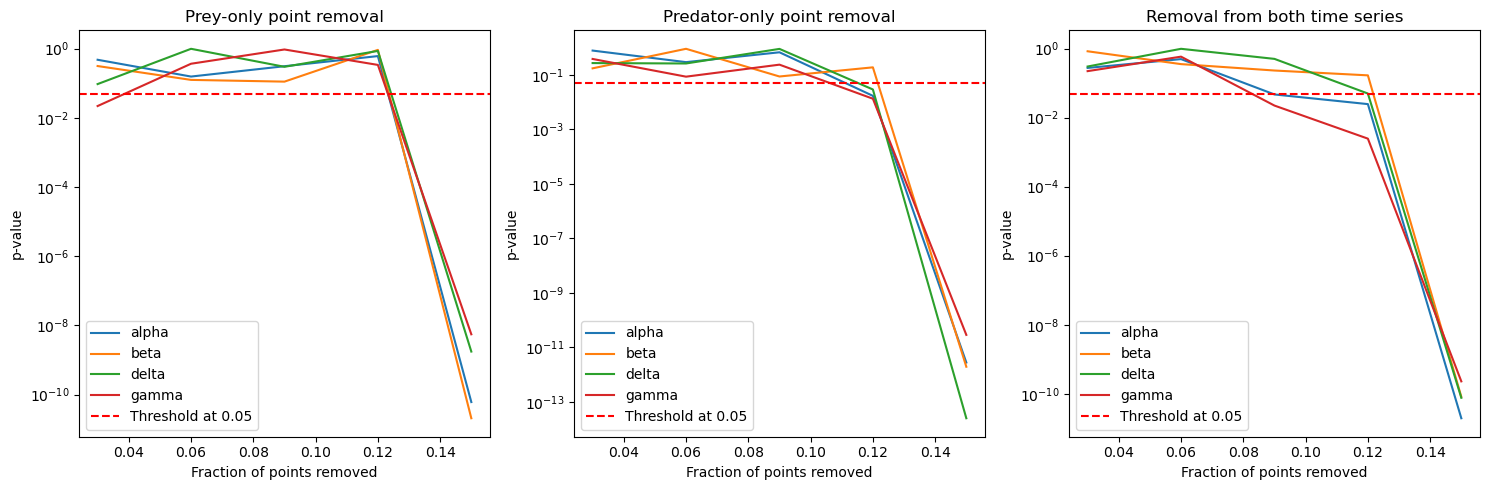

In [46]:

# Fraction points removed

# Fraction points removed
fraction_points = np.arange(3,16,3) / 100
p_values_prey = np.array(p_values_annealing['prey'])
p_values_predator = np.array(p_values_annealing['predator'])
p_values_both = np.array(p_values_annealing['both'])

# Creating subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plotting p-values when only prey points are removed
axes[0].plot(fraction_points, p_values_prey[:, 0], label='alpha')
axes[0].plot(fraction_points, p_values_prey[:, 1], label='beta')
axes[0].plot(fraction_points, p_values_prey[:, 2], label='delta')
axes[0].plot(fraction_points, p_values_prey[:, 3], label='gamma')
axes[0].axhline(y=0.05, color='r', linestyle='--', label='Threshold at 0.05')
axes[0].set_ylabel('p-value')
axes[0].set_xlabel('Fraction of points removed')
axes[0].set_yscale('log')
axes[0].set_title('Prey-only point removal')  # Add title to the first subplot
axes[0].legend()

# Plotting p-values when only predator points are removed
axes[1].plot(fraction_points, p_values_predator[:, 0], label='alpha')
axes[1].plot(fraction_points, p_values_predator[:, 1], label='beta')
axes[1].plot(fraction_points, p_values_predator[:, 2], label='delta')
axes[1].plot(fraction_points, p_values_predator[:, 3], label='gamma')
axes[1].axhline(y=0.05, color='r', linestyle='--', label='Threshold at 0.05')
axes[1].set_ylabel('p-value')
axes[1].set_xlabel('Fraction of points removed')
axes[1].set_yscale('log')
axes[1].set_title('Predator-only point removal')
axes[1].legend()

# Plotting p-values when both prey and predator points are removed
axes[2].plot(fraction_points, p_values_both[:, 0], label='alpha')
axes[2].plot(fraction_points, p_values_both[:, 1], label='beta')
axes[2].plot(fraction_points, p_values_both[:, 2], label='delta')
axes[2].plot(fraction_points, p_values_both[:, 3], label='gamma')
axes[2].axhline(y=0.05, color='r', linestyle='--', label='Threshold at 0.05')
axes[2].set_ylabel('p-value')
axes[2].set_xlabel('Fraction of points removed')
axes[2].set_yscale('log')
axes[2].set_title('Removal from both time series')
axes[2].legend()

plt.savefig('welch_test_annealing', dpi=300)

# Adjusting layout
plt.tight_layout()
plt.show()